__Assignment 8__

1. [Import](#Import)
1. [Assignment 8](#Assignment-8)
    1. [Load-data](#Load-data)
    1. [Stochastic gradient descent](#Stochastic-gradient-descent)    
    1. [Visualize results](#Visualize-results)    

# Import

<a id = 'Import'></a>

In [5]:
# standard libary and settings
import os
import sys
import itertools
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.options.display.float_format = "{:,.6f}".format

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

# magic functions
%matplotlib inline

# Assignment 8

1. Using the dataset HealthInCities implement Linear Regression using Stochastic Gradient Descent:

Try to predict the DeathRate (y) based on more than one of the other variables (X) and report on your findings.

Hint: In order to discern whether your “converged” w weights are good try to have X to be DoctorAvailability and the normalized column of zeroes (as we have done in the lecture video), that way we can find DeathRate = DoctorAvailability*w0 + w1 for our two weights in this case and we can plot it just like in the video to see if the line fits our data well. Also, don’t forget to standardize your data (mean = 0, and variance = 1) for meaningful interpretation of our results.

Note: We have covered Batch Gradient Descent which we recall is computationally efficient for smaller datasets as we are computing the w weights considering all of our data X (the whole matrix). In practice, if we are working with Big Data, it no longer becomes computationally efficient and feasible to process all of the X matrix at once, hence, we process it incrementally in a stochastic way. This is where Stochastic Gradient Descent comes in. The basic idea is to step in the direction of the optimal w by considering each sample of X one by one while also considering an outer loop where we take into account how many epochs (number of times we want to go over each X sample one by one). We want to choose an epoch number which is not too large (i.e. 1-10) so that our algorithm completes in an acceptable amount of time, but we also want to ensure we are converging, so an epoch number that is too small may not guarantee convergence. The ideal epoch number can be left up to experimentation when crafting the code as it is data-dependent.

Deliverables:

-One .ipynb pertaining to Linear Regression using Stochastic Gradient Descent on the HelathInCities dataset. Print out the optimal weights w, and write one paragraph interpreting what the w weights mean in your example, this can be done as markdown in your .ipynb or perhaps a print statement at the end.

<a id = 'Assignment-8'></a>

## Load data

<a id = 'Load-data'></a>

In [6]:
# load and inspect raw data
health_cities_raw = pd.read_csv("s3://tdp-ml-datasets/misc/HealthInCities.csv")
health_cities_raw.info()
display(health_cities_raw[:5])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 5 columns):
DeathRate               53 non-null float64
DoctorAvailability      53 non-null int64
HospitalAvailability    53 non-null int64
IncomePerCapita         53 non-null float64
PopulationDensity       53 non-null int64
dtypes: float64(2), int64(3)
memory usage: 2.1 KB


,DeathRate,DoctorAvailability,HospitalAvailability,IncomePerCapita,PopulationDensity
0,8.000000,78,284,9.100000,109
1,9.300000,68,433,8.700000,144
2,7.500000,70,739,7.200000,113
3,8.900000,96,1792,8.900000,97
4,10.200000,74,477,8.300000,206


In [7]:
# manually applying standard scaling to data
for column in health_cities_raw.columns:
    col_mean = np.mean(health_cities_raw[column])
    col_stdev = np.std(health_cities_raw[column])
    health_cities_raw[column] = (health_cities_raw[column] - col_mean) / col_stdev
health_cities_raw["bias"] = 0
health_cities_raw[:5]

,DeathRate,DoctorAvailability,HospitalAvailability,IncomePerCapita,PopulationDensity,bias
0,-0.792861,-1.015105,-0.928147,-0.315277,-0.035126,0
1,-0.003437,-1.281577,-0.475900,-0.690778,0.713818,0
2,-1.096485,-1.228282,0.452878,-2.098901,0.050468,0
3,-0.246337,-0.535457,3.648964,-0.503028,-0.291906,0
4,0.543087,-1.121694,-0.342350,-1.066277,2.040517,0


## Stochastic gradient descent

<a id = 'Stochastic-gradient-descent'></a>

In [8]:
# manual train test split
training_data = health_cities_raw.sample(frac=0.5, replace=True)
test_data = health_cities_raw.sample(frac=0.5, replace=True)

# training data
Y_train = training_data.iloc[:, 0].values
X_train = training_data[["DoctorAvailability", "bias"]].values

# test Data
Y_test = test_data.iloc[:, 0].values
X_test = test_data[["DoctorAvailability", "bias"]].values

In [9]:
# custom functions for plotting stochastic gradient descent
def learning_schedule(t, t0, t1):
    """Function for gradually decreasing learning rate"""
    return t0 / (t + t1)


def stochasticGradientDescent(X, y, weights, epochs, t0, t1):
    """
    Function for executing stochastic gradient descent.
    Initiate function with random weight values and a preferred number of epochs.
    Also declare t0 and t1, which control the learning rate, which gets smaller with each epoch.
    Pass in X and y as the training observations and labels, shuffle at the beginning of each epoch.
    Update the weights once for each sample. 
    """
    # Execute SGD and visualize first few iterations
    m = X.shape[0]
    for epoch in range(epochs):
        shuffledIx = np.random.permutation(m)
        X = X[shuffledIx]
        y = y[shuffledIx]
        for i in np.arange(m):
            xi = X[i : i + 1]
            yi = y[i : i + 1]
            gradients = (1 / len(xi)) * np.dot(xi.T, (np.dot(xi, weights) - yi))
            eta = learning_schedule(t=epoch * m + 1, t0=t0, t1=t1)
            weights = weights - eta * gradients
    return weights


# Execute
weights = stochasticGradientDescent(
    X=X_train, y=Y_train, weights=np.random.rand(2, 1), epochs=50, t0=1, t1=10
)
print("Learned weights: {0}".format(weights))

Learned weights: [[-0.00412068]
 [ 0.29896427]]


## Visualize results

<a id = 'Visualize-results'></a>

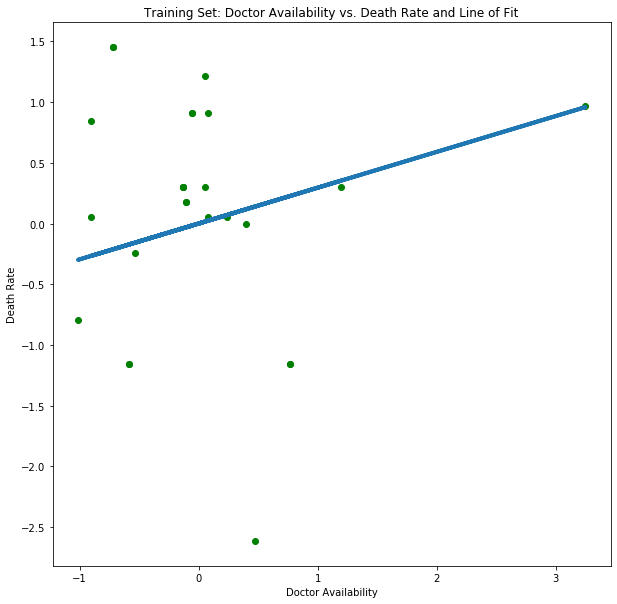

In [10]:
# plot values and overlay line of best fit
train_prediction = np.array(
    [sum(X_train[i] * weights) for i in range(X_train.shape[0])]
)

# plotting our points and line of fit (model)
plt.figure(figsize=(10, 10))
plt.plot(training_data["DoctorAvailability"], Y_train, "go")
plt.plot(training_data["DoctorAvailability"], train_prediction[:, 0], linewidth=4)
plt.title("Training Set: Doctor Availability vs. Death Rate and Line of Fit")
plt.xlabel("Doctor Availability")
plt.ylabel("Death Rate")
plt.show()

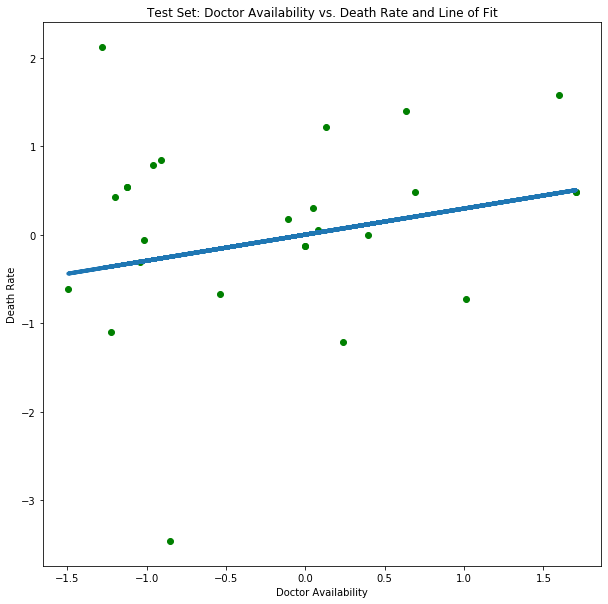

In [11]:
# repeat plot for test data
test_prediction = np.array([sum(X_test[i] * weights) for i in range(X_test.shape[0])])

# plotting our points and line of fit (model)
plt.figure(figsize=(10, 10))
plt.plot(test_data["DoctorAvailability"], Y_test, "go")
plt.plot(test_data["DoctorAvailability"], test_prediction[:, 0], linewidth=4)

plt.title("Test Set: Doctor Availability vs. Death Rate and Line of Fit")
plt.xlabel("Doctor Availability")
plt.ylabel("Death Rate")
plt.show()

In [12]:
# review RSS of train and test sets
print(
    "Training sum of squared errors with regularization:",
    sum([res ** 2 for res in Y_train - train_prediction[:, 0]]),
)
print(
    "Test sum of squared errors with regularization:",
    sum([res ** 2 for res in Y_test - test_prediction[:, 0]]),
)

Training sum of squared errors with regularization: 24.97200701700268
Test sum of squared errors with regularization: 28.991048230988103


In [13]:
# review weight learned by model
print("Learned weights: {0}".format(weights))

Learned weights: [[-0.00412068]
 [ 0.29896427]]


> Remarks - In the code executed above, the line of best fit is determined using stochastic gradient descent, and the line of best fit is overlayed on both the training and test datasets. The optimal weights are shown directly above: the weight for the standardized 'DoctorAvailability' feature is -0.1388, and the weight for the bias column is 0.3321. An interpretation of the 'DoctorAvailability' weight could be that for every 1 unit increase in doctor availability the death rate decreasing by 0.1388. Again, this is standardized, but the point is that doctor availability appears to decrease the death rate, which makes sense.